In [2]:
import alpaca_trade_api as alpaca
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
sns.set(font_scale= .7)
from pylab import rcParams

In [3]:
alpaca_api = alpaca.REST('PKU5LEIDZZV83Y5ENASI', 'nvzOwJpyvr73GTitTDyga0MkI2Qd6RsK4PmhItbu', api_version='v2')
# Set the ticker symbol and time frame
ticker = "TSLA"
timeframe = "1Day"
start_date = "2016-01-01T00:00:00-00:00"
end_date = "2024-01-01T00:00:00-00:00"

# Retrieve the data
tsla = pd.DataFrame(alpaca_api.get_bars(ticker,  timeframe, start_date, end_date).df)
#df = pd.DataFrame(data)

# # Calculate the 3 period moving average of the close
# df['Mid']=(df['high']+df['low'])/2
# #df['Mid']=df['high']
# df['3MA'] = df['close'].rolling(3).mean()

# df['2MA'] = df['close'].rolling(2).mean()

# # Calculate the 10 period moving average of the close
# df['10MA'] = df['close'].rolling(10).mean()

# # Calculate the 20 period moving average of the close
# #df['20MA'] = df['close'].rolling(20).mean()

# df['Diff']=df['3MA']-df['10MA']

# df['3MASlope']=df['3MA'].pct_change()
# df['2MASlope']=df['2MA'].pct_change()
# df['10MASlope']=df['10MA'].pct_change()
# df['vwap']=df['vwap'].pct_change()
# df['CloseDiff3MA']=df['close']/df['3MA']
# df['open']=df['open'].pct_change().shift(-1)
# df['close']=df['close'].pct_change().shift(-1)
# df['Mid']=df['Mid'].pct_change()
# df=df.drop(columns=['high','low','volume','trade_count'])
# df['FutureMid']=df['Mid'].shift(-1)
           
# df["Signal"] = 0.0
           



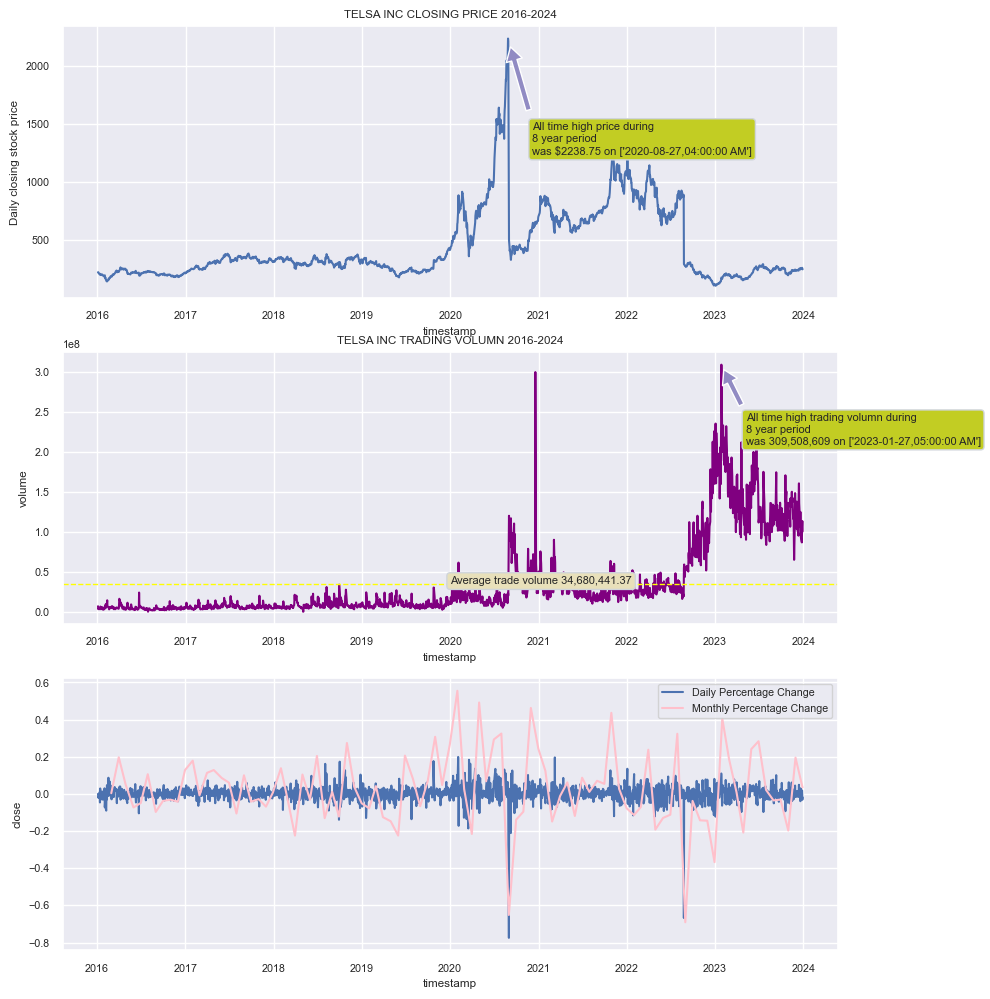

In [4]:
# visualize the data
plt.rcParams['font.size'] = 8
fig, axes = plt.subplots(3,1,figsize=(10,12))
sns.lineplot(x=tsla.index,y=tsla.close, ax=axes[0]).set_title('TELSA INC CLOSING PRICE 2016-2024')
axes[0].set_ylabel("Daily closing stock price")
high = tsla['close'].max()
dateHigh= tsla[tsla['close'] == high].index
axes[0].annotate(f"All time high price during\n8 year period\nwas ${high} on {dateHigh.strftime('%Y-%m-%d,%r').values}", 
                 xy=(dateHigh,high),xytext=(dateHigh+pd.DateOffset(days=100)  ,high-1000),
                bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))
sns.lineplot(x=tsla.index,y=tsla.volume,ax=axes[1], color='purple').set_title('TELSA INC TRADING VOLUMN 2016-2024')
highVal = tsla['volume'].max()
dateHighVal= tsla[tsla['volume'] == highVal].index
axes[1].annotate(f"All time high trading volumn during\n8 year period\nwas {highVal:,} on {dateHighVal.strftime('%Y-%m-%d,%r').values}", 
                 xy=(dateHighVal,highVal),xytext=(dateHighVal+pd.DateOffset(days=100)  ,highVal-10**8),
                bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))
axes[1].axhline(y=tsla['volume'].mean(), linestyle='--',lw=1, color='yellow')
axes[1].annotate(f"Average trade volume {round(tsla['volume'].mean(),2):,}", 
                xy=(tsla.index.mean(),tsla.volume.mean()),xytext=(tsla.index.mean(),tsla.volume.mean()),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )

sns.lineplot(x=tsla.index, y=tsla.close.pct_change(fill_method='bfill'), label='Daily Percentage Change',ax=axes[2])
#monthly percent change of stock closing price based on the last day of each month 
monthR= tsla.resample('BM').apply(lambda x:x[-1])
#highValM= monthR.close.pct_change(fill_method='bfill').abs().max()
#dateHighValM= monthR[monthR['close'].pct_change()== highValM].index
sns.lineplot(x=monthR.index, y=monthR.close.pct_change(fill_method='bfill'), label='Monthly Percentage Change',ax=axes[2], color='pink')
#axes[2].annotate(f"All time highest percentage change during\n8 year period\nwas {highValM:,} on {dateHighValM.strftime('%Y-%m-%d,%r').values}", 
#                xy=(dateHighValM,highValM),xytext=(dateHighValM+pd.DateOffset(days=100) ,highValM-5),
#                bbox=dict(boxstyle="round",facecolor='#C2CD23', edgecolor='#d0d5db'),
#                arrowprops=dict(facecolor="#918BC3",headlength=10, shrink=0.1))

plt.show()

In [34]:
def check_stationarity(series):
    '''Test the null hypothesis of non-stationary time series data,
    if the pvalue is smaller than 0.05 threshold, reject the hypothesis'''
    if len(series) < 10:  # Adjust the threshold as needed
        print("Series is too short to perform ADF test.")
        return None
    
    result = adfuller(series, autolag='AIC', regression='ct')

    print('ADF Statistic: %f' % result[0])
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")
    return result
r= check_stationarity(tsla.close)

ADF Statistic: -2.789265
p-value: 0.2009150764202664
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Non-stationary


additive 20
ADF Statistic: -12.780596
p-value: 2.6449092252724123e-20
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary


multiplicative 20
ADF Statistic: -14.517633
p-value: 4.236897488475969e-22
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
additive 12
ADF Statistic: -15.510408
p-value: 1.382464399938686e-22
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
multiplicative 12
ADF Statistic: -14.415606
p-value: 5.011907856854788e-22
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
additive 252
ADF Statistic: -4.779979
p-value: 0.0005076808258104237
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
multiplicative 252
ADF Statistic: -14.663637
p-value: 3.3884643613408632e-22
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary


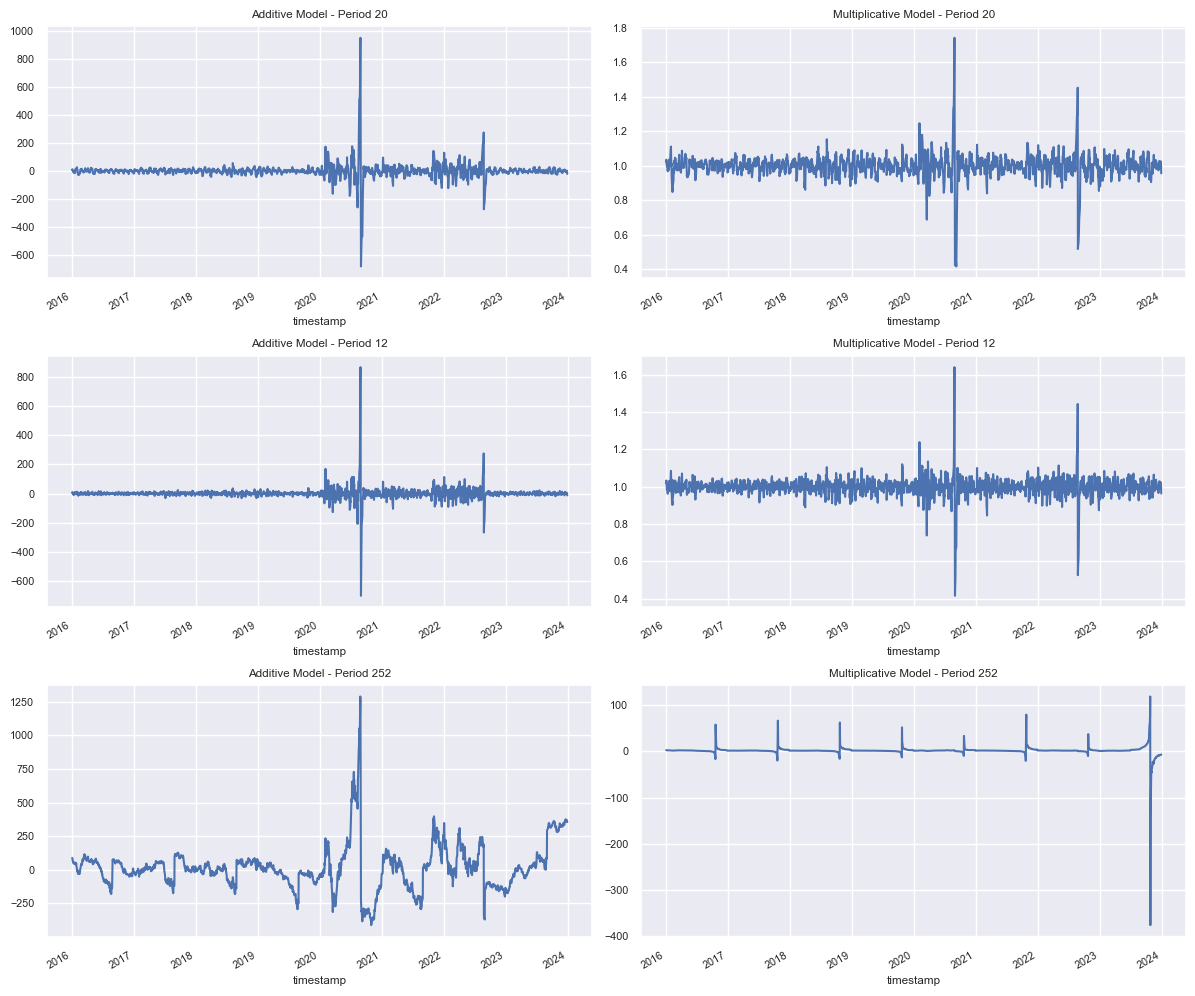

In [24]:
def decomposition(closingP, periodList):
    adfR={}
    fig, axes= plt.subplots(nrows=3, ncols=2, figsize=(12,10))
    for row,period in enumerate(periodList):
        modelList=['additive','multiplicative']
        for col, model in enumerate(modelList):
            # decompistion instance
            result_decom = seasonal_decompose(closingP, model=model, 
                                            period=period, extrapolate_trend='freq')
            # plot the componenets 
            result_decom.resid.plot(ax=axes[row,col])
            axes[row, col].set_title(f"{model.capitalize()} Model - Period {period}")
            plt.tight_layout()
            #trend = result_decom.trend
            #season = result_decom.seasonal
            reside = result_decom.resid
            print(model,period)
            adfResults=check_stationarity(reside)
            adfR[model,period]= adfResults
    plt.show()
    return adfR
#20 trading days per month, and 253 per year
#not much variability in the residuals except for the tear of 2020, while strong seasonality is reflected 
a= decomposition(tsla.close, [20,12,252])

In [14]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: f'{x:.2e}')
b=pd.concat({k: pd.DataFrame(v).T for k, v in a.items()}, axis=0)
b.columns=['adf_statistics','pVal','usedLag','nObs','criticalVal','icbest']
b

,,,adf_statistics,pVal,usedLag,nObs,criticalVal,icbest
additive,20,0,-1.28e+01,2.64e-20,26,1985,"{'1%': -3.963337987636336, '5%': -3.4127040874844554, '10%': -3.128353568266929}",2.03e+04
multiplicative,20,0,-1.45e+01,4.24e-22,18,1993,"{'1%': -3.9633196225280947, '5%': -3.4126951908137797, '10%': -3.1283483316744842}",-6.59e+03
additive,12,0,-1.55e+01,1.38e-22,24,1987,"{'1%': -3.963333382473333, '5%': -3.4127018565936336, '10%': -3.1283522551626364}",1.99e+04
multiplicative,12,0,-1.44e+01,5.01e-22,18,1993,"{'1%': -3.9633196225280947, '5%': -3.4126951908137797, '10%': -3.1283483316744842}",-6.95e+03
additive,253,0,-4.95e+00,2.55e-04,26,1985,"{'1%': -3.963337987636336, '5%': -3.4127040874844554, '10%': -3.128353568266929}",2.06e+04
multiplicative,253,0,-4.04e+01,0.00e+00,0,2011,"{'1%': -3.963278836113111, '5%': -3.4126754323752686, '10%': -3.1283367017897814}",1.66e+04


In [15]:
#The best performing model was the multiplicative model with a period set to 12month, differencing on that
def detectDiff(timeseries,period ):
    info=[]
    #d=0/1/2
    for i in range(3):
        timeseries.name=f"d{i}_Only"
        info.append(timeseries)
        timeseries=timeseries.diff()
    
    #seasonalD given d=0/1/2
    for i in period:
        for j in range(3):
            timeseries= info[j].diff(periods=i)
            timeseries.name = f"d{j}_SeasonalD{i}"
            info.append(timeseries)
    return pd.DataFrame(info).T

In [17]:
a= detectDiff(tsla.close,[12])
a

,d0_Only,d1_Only,d2_Only,d0_SeasonalD12,d1_SeasonalD12,d2_SeasonalD12
timestamp,,,,,,
2016-01-04 05:00:00+00:00,2.23e+02,NaN,NaN,NaN,NaN,NaN
2016-01-05 05:00:00+00:00,2.23e+02,2.00e-02,NaN,NaN,NaN,NaN
2016-01-06 05:00:00+00:00,2.19e+02,-4.39e+00,-4.41e+00,NaN,NaN,NaN
2016-01-07 05:00:00+00:00,2.16e+02,-3.39e+00,1.00e+00,NaN,NaN,NaN
2016-01-08 05:00:00+00:00,2.11e+02,-4.65e+00,-1.26e+00,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-22 05:00:00+00:00,2.53e+02,-1.96e+00,-9.32e+00,1.32e+01,-2.61e+00,-6.83e+00
2023-12-26 05:00:00+00:00,2.57e+02,4.07e+00,6.03e+00,1.40e+01,8.00e-01,3.41e+00
2023-12-27 05:00:00+00:00,2.61e+02,4.83e+00,7.60e-01,1.76e+01,3.63e+00,2.83e+00


In [18]:
#d=1,D=1 generate wioth the lowest pval
for col in a.columns.to_list():
    print('For',col)
    check_stationarity(a[col].dropna())

For d0_Only
ADF Statistic: -2.789265
p-value: 0.2009150764202664
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Non-stationary
For d1_Only
ADF Statistic: -15.066583
p-value: 2.0303168003719562e-22
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
For d2_Only
ADF Statistic: -16.620053
p-value: 0.0
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
For d0_SeasonalD12
ADF Statistic: -6.938384
p-value: 1.9469135718194204e-08
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
For d1_SeasonalD12
ADF Statistic: -16.194403
p-value: 0.0
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary
For d2_SeasonalD12
ADF Statistic: -18.307540
p-value: 0.0
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary


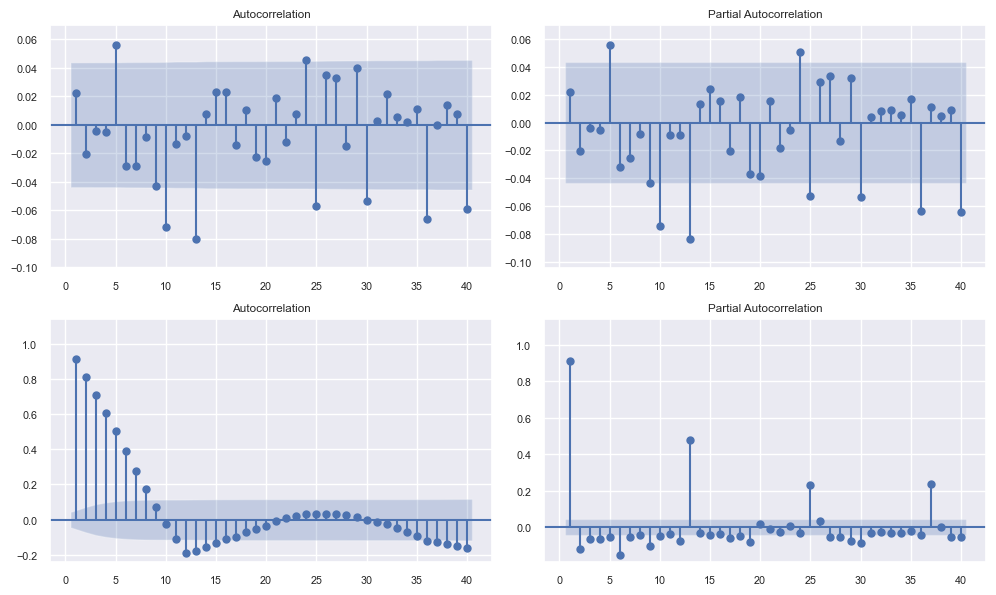

In [21]:
# overdifferenced since the first lag of acf plot is negatitve, 
# adding and moving averae to the model with order 2, since that is the lag where the acf plot cus off. 
import statsmodels.api as sm
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
sm.graphics.tsa.plot_acf(a['d1_Only'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[0][0])
sm.graphics.tsa.plot_pacf(a['d1_Only'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[0][1])

sm.graphics.tsa.plot_acf(a['d0_SeasonalD12'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[1][0])
sm.graphics.tsa.plot_pacf(a['d0_SeasonalD12'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[1][1])

#sm.graphics.tsa.plot_acf(a['d1_SeasonalD20'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[2][0])
#sm.graphics.tsa.plot_pacf(a['d1_SeasonalD20'].dropna(), lags=40, zero=False, auto_ylims=True, ax=ax[2][1])

#p 2, d=1, q=2
plt.tight_layout()
plt.show()

In [48]:
rolling_mean

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-12-22 05:00:00+00:00,2.48e+02,2.51e+02,2.43e+02,1.17e+06,2.47e+02,1.16e+08,2.47e+02
2023-12-26 05:00:00+00:00,2.49e+02,2.52e+02,2.44e+02,1.17e+06,2.48e+02,1.15e+08,2.49e+02
2023-12-27 05:00:00+00:00,2.50e+02,2.53e+02,2.46e+02,1.17e+06,2.49e+02,1.15e+08,2.50e+02


<AxesSubplot: title={'center': 'after rolling mean & differencing'}, xlabel='timestamp'>

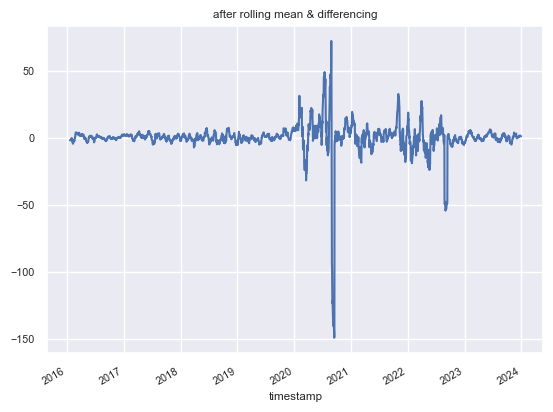

In [49]:
rolling_mean= tsla.close.rolling(window=12).mean()
tsla['rolling_mean_diff_close']= rolling_mean.diff()
tsla['rolling_mean_diff_close'].plot(title='after rolling mean & differencing')

In [28]:
import pmdarima as pmd
#Best model:  ARIMA(0,1,0)(0,0,2)[20]  
model=pmd.auto_arima(tsla['close'],start_p=1,start_q=1,test='adf',m=12,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=21141.713, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=21142.084, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=21145.054, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=21145.023, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=21140.084, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=21143.966, Time=0.30 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=21143.975, Time=0.30 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=21140.412, Time=1.31 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=21143.118, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=21143.077, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=21143.169, Time=0.66 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 6.321 seconds


In [29]:
model=SARIMAX(tsla.close, order=(0,1,0), seasonal_order=(0,0,2,12)).fit()
model.params.to_frame('SARIMAX')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25235D+00    |proj g|=  2.84966D-03

At iterate    5    f=  5.25221D+00    |proj g|=  1.04872D-02

At iterate   10    f=  5.25200D+00    |proj g|=  2.64643D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   1.224D-06   5.252D+00
  F =   5.2520007321366409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


,SARIMAX
ma.S.L12,-1.81e-03
ma.S.L24,4.39e-02
sigma2,2.15e+03


In [30]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                 d0_Only   No. Observations:                 2012
Model:             SARIMAX(0, 1, 0)x(0, 0, [1, 2], 12)   Log Likelihood              -10567.025
Date:                                 Fri, 12 Apr 2024   AIC                          21140.051
Time:                                         17:24:00   BIC                          21156.870
Sample:                                              0   HQIC                         21146.225
                                                - 2012                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0018      0.033     -0.054      0.957      -0.067       0.064
ma.S.L24       0.0439      0.014      3.138      0.002       0.016       0.071
sigma2      2145.9213      5.753    372.989      0.000    2134.645    2157.198
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):          74211697.26
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):              19.82   Skew:                           -26.03
Prob(H) (two-sided):                  0.00   Kurtosis:                       942.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
#####another approach
import numpy as np
tslaLog= np.log(tsla)
tslaDiffL= tslaLog.diff(12).dropna()

p=check_stationarity(tslaDiffL.close)

ADF Statistic: -6.921968
p-value: 2.1201392618364033e-08
Critical Values:
	1%: -3.963
	5%: -3.413
	10%: -3.128
Stationary


In [40]:
sarimax_model = SARIMAX(endog=tslaDiffL.close.dropna().values, trend='ct',
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39414D-01    |proj g|=  9.59045D-01

At iterate    5    f= -1.10311D+00    |proj g|=  2.13345D+00

At iterate   10    f= -1.14944D+00    |proj g|=  1.46780D+00

At iterate   15    f= -1.32560D+00    |proj g|=  8.45443D-01

At iterate   20    f= -1.37713D+00    |proj g|=  2.19561D-01

At iterate   25    f= -1.44116D+00    |proj g|=  7.34561D-01

At iterate   30    f= -1.46172D+00    |proj g|=  4.08042D-02

At iterate   35    f= -1.46326D+00    |proj g|=  1.98547D-02

At iterate   40    f= -1.46346D+00    |proj g|=  1.33180D-01
  ys=-1.803E-06  -gs= 1.235E-06 BFGS update SKIPPED
  ys=-6.100E-02  -gs= 2.344E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f= -1.46354D+00    |proj g|=  4.38738D-03

At iterate   50    f= -1.46355D+00    |proj g|=  1.36098D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50    104      2     2     0   1.361D-02  -1.464D+00
  F =  -1.4635532178053658     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [41]:
print(sarimax_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                 2000
Model:             SARIMAX(2, 0, 2)x(1, 0, [1], 12)   Log Likelihood                2927.106
Date:                              Fri, 12 Apr 2024   AIC                          -5840.213
Time:                                      17:33:49   BIC                          -5801.007
Sample:                                           0   HQIC                         -5825.817
                                             - 2000                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0005      0.000      2.626      0.009       0.000       0.001
ar.L2          0.99

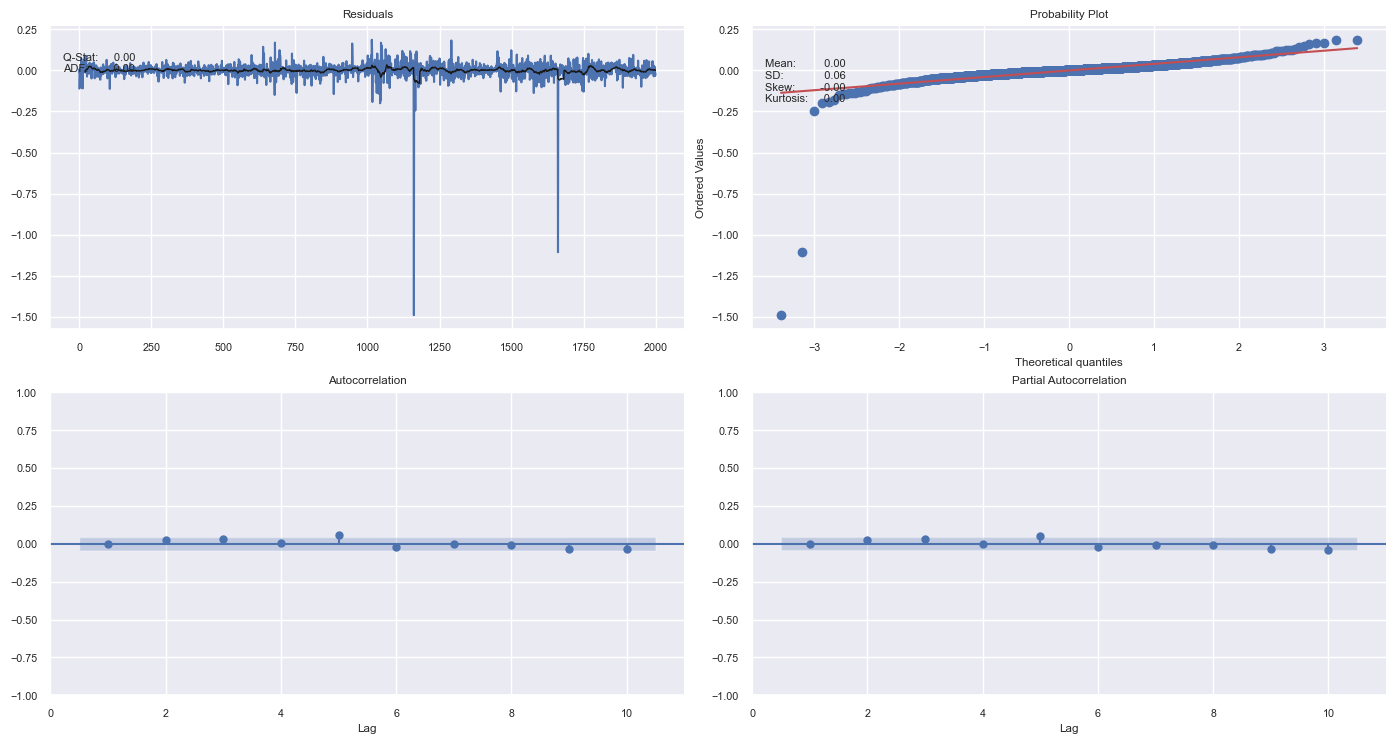

In [45]:
from statsmodels.tsa.stattools import acf, q_stat
from scipy.stats import probplot, moment
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
plot_correlogram(pd.Series(sarimax_model.resid))

In [ ]:
for index, row in df.iterrows():
    if row["Mid"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["Mid"] < 0:
        df.loc[index,"Signal"] = -1.0

'''for index, row in df.iterrows():
    if row["close"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["close"] < 0:
        df.loc[index,"Signal"] = 0'''
        
'''for index, row in df.iterrows():
    if row["vwap"] >= 0:
       df.loc[index, "Signal"] = 1.0
    if row["vwap"] < 0:
        df.loc[index,"Signal"] = 0.0'''
        
# Calculate the points in time at which a position should be taken, 1 or -1
#ema_signals_df['Crossover']= ema_signals_df['Signal'].diff()
#ema_signals_df=ema_signals_df.dropna()
#ema_signals_df['Crossover']=ema_signals_df['Crossover'].shift(-8)
df["Signal"]=df["Signal"].shift(-1)
df['FutureSlope']=df["close"].shift(-1)

'''ema_signals_df['Crossover']=ema_signals_df['Signal'].diff()
# Review the DataFrame
#ema_signals_df=ema_signals_df['Crossover'].dropna()
ema_signals_df=ema_signals_df.dropna()'''
df.tail(10)

In [ ]:
#display(df.hvplot.scatter(y='CloseDiff3MA',x='3MASlope'))

lstColumns=df.columns

display(lstColumns)

dfopt=pd.DataFrame()

for column in lstColumns:
    display(df.hvplot.scatter(y='FutureMid',x=column))
    dfopt=df[['FutureMid',column]]
    display(dfopt.corr())

In [ ]:
df=df.dropna()

y = df['Signal']

# Review the value counts
y.value_counts()

In [ ]:
df

In [ ]:
# Select the start of the training period

from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

X = df[['10MASlope','2MASlope','CloseDiff3MA']].dropna()




training_begin = X.index.min()

# Display the training begin date
print(training_begin)

training_end = X.index.min() + DateOffset(months=48)

# Display the training end date
print(training_end)

# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
display(X_train.tail())

# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

display(X_test_scaled)

In [ ]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC(probability=True) 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


In [ ]:
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression()

model=logModel.fit(X_train_scaled, y_train)
log_pred=logModel.predict(X_test_scaled)

log_testing_report = classification_report(y_test, log_pred)

print(log_testing_report)


In [ ]:
4991/9151

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

predictions_df["predicted_signal"] = svm_pred

predictions_df["actual_returns"] = df["vwap"].shift(-1)

predictions_df["trading_algorithm_returns"] = (
    predictions_df["actual_returns"] * predictions_df["predicted_signal"]
)

# Review the DataFrame
display(predictions_df['predicted_signal'].value_counts())
predictions_df.head()

In [ ]:
(1 + predictions_df[["actual_returns", "trading_algorithm_returns"]]).cumprod().plot()

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np


y_probs = svm_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Find the threshold with the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(precision)
best_threshold = thresholds[best_threshold_index]

# Make predictions with the best threshold
y_pred = (y_probs <= best_threshold).astype(int)

In [ ]:
print(best_threshold)

print(np.argmax(precision))

svm_testing_report = classification_report(y_test, y_pred)

# Print the classification report
print(svm_testing_report)

In [ ]:
X_test

In [ ]:
for x in range(1,100,1):
    threshold=float(x)/100
    print(threshold)
    y_pred = (y_probs >= threshold).astype(int)
    svm_testing_report = classification_report(y_test, y_pred)

    # Print the classification report
    print(svm_testing_report)
    
    